In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

In [2]:
# ugly hack to get relative imports working
import os
os.chdir("..")

In [3]:
def hazard(p):
    def geometric(t):
        return p * (1 - p) ** t
    return geometric

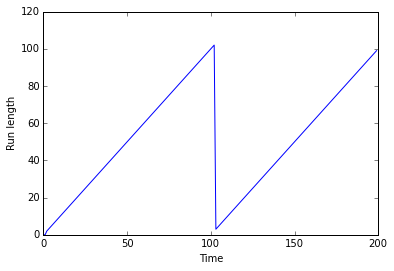

In [4]:
from bcd import offline_changepoint_detection
from bcd.distributions import Gaussian

data = [0] * 100 + [1] * 100
Pr = offline_changepoint_detection(data, hazard(0.6), Gaussian(0.1, 0.1, 0, 1))

plt.plot([Pr[:, t].argmax() for t in range(len(data))])
plt.xlabel("Time")
plt.ylabel("Run length")
plt.show()

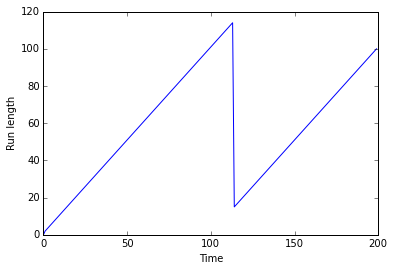

In [5]:
from bcd import BayesianChangepointDetection
from bcd.distributions import StudentT

detector = BayesianChangepointDetection(hazard(0.6), StudentT(0.1, 0.1, 1, 1))

Pr = [detector.step(x) for x in data]

plt.plot([pr.argmax() for pr in Pr])
plt.xlabel("Time")
plt.ylabel("Run length")
plt.show()

In [6]:
from data.yahoo import get_stock_prices
import datetime as dt

prices = [start for start, __ in get_stock_prices("GOOG", dt.date(2010, 1, 1))]

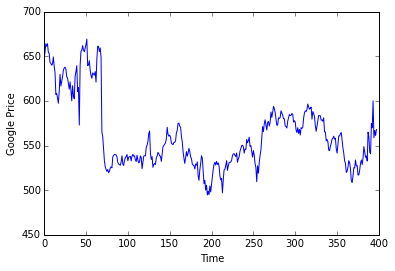

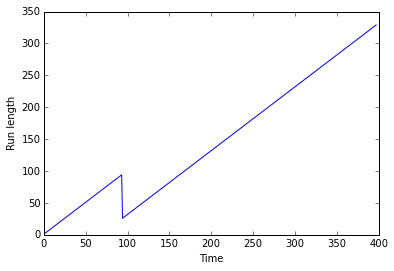

In [7]:
detector = BayesianChangepointDetection(hazard(0.4), StudentT(0.1, 0.1, 1, 1))
Pr = [detector.step(start) for start in prices]

plt.plot(prices)
plt.xlabel("Time")
plt.ylabel("Google Price")
plt.show()

plt.plot([pr.argmax() for pr in Pr])
plt.xlabel("Time")
plt.ylabel("Run length")
plt.show()

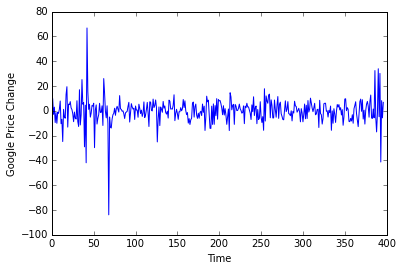

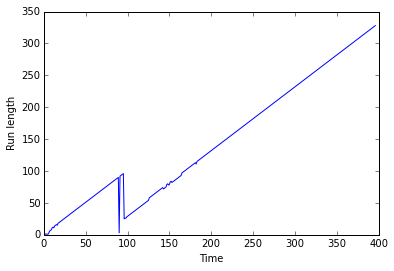

In [8]:
detector = BayesianChangepointDetection(hazard(0.3), StudentT(0.1, 0.1, 1, 1))
diff = np.diff(prices)
Pr = [detector.step(d) for d in diff]

plt.plot(diff)
plt.xlabel("Time")
plt.ylabel("Google Price Change")
plt.show()

plt.plot([pr.argmax() for pr in Pr])
plt.xlabel("Time")
plt.ylabel("Run length")
plt.show()